In [223]:
import pandas as pd
from typing import List
from scipy.linalg import lstsq
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_excel('files/smspecs_yearly.xlsx', sheet_name=None,  index_col=0)
class Variant:
    __slots__ = ['full_name', 'dates', '_df', '_trendC00', '_r2']
    @classmethod
    def from_xls_smspecs_yearly(cls, df, key):
        obj = cls()
        obj.full_name = key
        # obj.name =int(key.split('-')[0],base=2)
        obj.dates = [9999 if line=='xxxx' else int(line) for line in key.split('-')[1:]]
        obj._df = df / 10**9
        obj._trendC00 = None
        obj._r2 = None
        return obj
    @property
    def name(self) -> int: return int(self.full_name.split('-')[0],base=2)
    def __repr__(self) -> str:
        return '\n'.join([
            repr(self._df),
            f'name={self.name:03b} dates={self.dates}'
        ]) 
    @property
    def get_trend(self)->List[float]:
        if self._trendC00 is None:
            deg = 4
            x_ar = self._df['total'].to_numpy()
            y_ar = self._df['yearly'].to_numpy()
            a_matrix = np.vstack([[v ** p for p in range(deg+1)] for v in x_ar])
            self._trendC00, resid=  lstsq(a_matrix, y_ar)[:2]
            self._r2 = 1 - resid / (y_ar.size / y_ar.var())
        return self._trendC00
    @property
    def r2(self)->float:
        if self._r2 is None:
            self.get_trend
        return self._r2
    def get_trend_val(self, val:float)->float:
        return sum([val ** ind * c00 for ind, c00 in enumerate(self.get_trend)])
    def show(self):
        fig, ax = plt.subplots()
        ax.plot(self._df.total, self._df.yearly, '.')
        x_arr = np.linspace(self._df.total.min(), self._df.total.max(), 20)
        ax.plot(x_arr, [ self.get_trend_val(x) for x in x_arr])
        plt.show()
base_var = Variant.from_xls_smspecs_yearly(df['000-xxxx-xxxx-xxxx'],'000-xxxx-xxxx-xxxx') 
arr_vars = [
    Variant.from_xls_smspecs_yearly(df[key],key)
    for key in filter(lambda k: k != '000-xxxx-xxxx-xxxx', df.keys() )]

# base_var

In [224]:


class Proxy:
    __slots__ = ['base_Variant', 'arr_Variant']
    def __init__(self, base_Variant:Variant, arr_Variant:List[Variant]) -> None:
        self.base_Variant = base_Variant
        self.arr_Variant = arr_Variant
    def get_dq(self, var_full_name:str)->pd.DataFrame:        
        var =  next(filter(lambda x: x.full_name == var_full_name,self.arr_Variant))
        total = self.base_Variant._df.total
        min_date = min(var.dates)        
        yearly_base = self.base_Variant._df.yearly
        res = {
            'total': total,
            # 'dq' :  np.array([
                # base_val if date.year < min_date else var_val
            # for base_val, var_val, date in zip(yearly_base, var._df.yearly, self.base_Variant._df.index)]) - yearly_base
            'dq': np.array([
                yearly if date.year < min_date else var.get_trend_val(v)
            for date, v, yearly in zip(var._df.index, total, yearly_base)]) - yearly_base #FIXME отрефакторить всю херню
        }
        df_res =  pd.DataFrame(res)
        return df_res[df_res['dq'] > 0]
    def get_var_by_name(self,name:int)->pd.DataFrame: return next(filter(lambda x: x.name == name,self.arr_Variant))
    def show(self): 
        fig, axs = plt.subplots(nrows=3, figsize=(10, 20))
        for ax, num in zip(axs,[1,2,4]):
            for var in filter(lambda var: var.name in [num], self.arr_Variant):            
                df = self.get_dq(var.full_name)
                line, = ax.plot(df.total, df.dq, 'o-')
                line.set_label(var.full_name)
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()
        plt.show()
        
p = Proxy(base_var, arr_vars)

# p.show()

           R2                vars
54   0.914876  101-2013-xxxx-2019
164  0.968039  111-2015-2015-2015
173  0.648047  111-2016-2013-2013
174  0.779473  111-2016-2013-2016
187  0.695422  111-2016-2017-2017


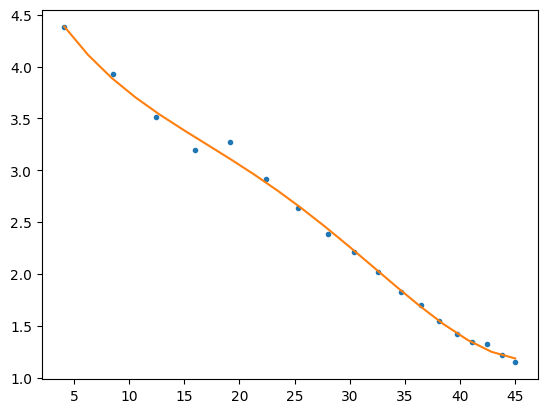

0.9970152624381594

In [225]:
df = pd.DataFrame({
    'R2':[var.r2 for var in p.arr_Variant],
    'vars':[var.full_name for var in p.arr_Variant]
    })
print(df[df.R2 < .97])

var = next(filter(lambda var: var.full_name == "010-xxxx-2017-xxxx", p.arr_Variant))
var.show()
var.r2
